In [35]:
!unzip anime_faces.zip

Streaming output truncated to the last 5000 lines.
 extracting: anime_faces/5499.png    
 extracting: anime_faces/55.png      
 extracting: anime_faces/550.png     
 extracting: anime_faces/5500.png    
 extracting: anime_faces/5501.png    
 extracting: anime_faces/5502.png    
 extracting: anime_faces/5503.png    
 extracting: anime_faces/5504.png    
 extracting: anime_faces/5505.png    
 extracting: anime_faces/5506.png    
 extracting: anime_faces/5507.png    
 extracting: anime_faces/5508.png    
 extracting: anime_faces/5509.png    
 extracting: anime_faces/551.png     
 extracting: anime_faces/5510.png    
 extracting: anime_faces/5511.png    
 extracting: anime_faces/5512.png    
 extracting: anime_faces/5513.png    
 extracting: anime_faces/5514.png    
 extracting: anime_faces/5515.png    
 extracting: anime_faces/5516.png    
 extracting: anime_faces/5517.png    
 extracting: anime_faces/5518.png    
 extracting: anime_faces/5519.png    
 extracting: anime_faces/552.png     

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data

In [102]:
import natsort
from torch.utils.data import DataLoader, Dataset, RandomSampler
from sklearn.model_selection import train_test_split
from PIL import Image
import os
batch_size = 128
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)
        #indices = np.random.permutation(len(self.total_imgs))
        #split_rate = 0.8
        #training_idx, test_idx = indices[:int(len(self.total_imgs)*split_rate)], indices[int(len(self.total_imgs)*split_rate):]
        #training_idx = training_idx.replace(' ', ',')
        #test_idx = test_idx.replace(' ', ',')
        #self.train_x, self.val_x = self.total_imgs[training_idx,:], self.total_imgs[test_idx,:]
    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc=self.total_imgs[idx]
        #print(img_loc)
        image = Image.open('anime_faces/'+img_loc)#.convert("RGB")
       
        x = self.transform(image)
        x = np.asarray(x)
        #x = x.reshape(1, x.shape[0], x.shape[1])
        x = torch.from_numpy(x)
        return x
train_transform = transforms.Compose([
    #transforms.Grayscale(1),
    transforms.Resize([28, 28]),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])
train_set = CustomDataSet("anime_faces", train_transform)
X_train, X_val = train_test_split(train_set, test_size=0.2) 


train_loader = DataLoader(
    X_train,
    batch_size=batch_size,
    #sampler=RandomSampler(train_set),
    #collate_fn=train_set.collate_fn,
                              
)
val_loader = DataLoader(
    X_val,
    batch_size=batch_size,
    #sampler=RandomSampler(test_set),
    #collate_fn=test_set.collate_fn,
)

# Model

In [103]:
import torch.distributions as td
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = logVar.exp().pow(0.5)         # logvar to std
        q_z = td.normal.Normal(mu, std)     # create a torch distribution
        z = q_z.rsample() 
        return z, q_z

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z, q_z = self.reparameterize(mu, logVar)
        #print(z.size())
        #print(z)
        out = self.decoder(z)
        return out, q_z

# Training

In [171]:
learning_rate = 1e-3
num_epochs = 800

net = VAE(imgChannels = 3).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses_his = []
valid_losses_his = []
min_loss = 10000

In [161]:
def loss_function(recon_x, x, q_z):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    p_z = td.normal.Normal(torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale))
    KLD = td.kl_divergence(q_z, p_z).sum()

    return BCE + KLD

In [ ]:

import copy
scale = 100
for epoch in range(num_epochs):
    total_loss = 0
    total_valloss = 0
    for idx, imagedata in enumerate(train_loader, 0):
        imgs = imagedata
        imgs = imgs.to(device)
        imgs = imgs*1.0
        #print(imgs.shape)
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, q_z = net(imgs)
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        #kl_divergence = scale * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        #print(imgs.size(), out.size())
        loss = loss_function(out, imgs, q_z)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    
    net.eval()

    with torch.no_grad():
        for imagedata in val_loader:
            imgs = imagedata
            imgs = imgs.to(device)
            imgs = imgs*1.0
            out, q_z = net(imgs)
            loss = loss_function(out, imgs, q_z)
            total_valloss+=loss.item()
        val_loss = total_valloss/len(X_val)
        if val_loss<min_loss:
            min_loss = val_loss
            best_model = copy.deepcopy(net)
        if not epoch % 10  and epoch != 0:
          train_losses_his.append(total_loss/len(X_train))
          valid_losses_his.append(val_loss)
    print(f'| end of epoch {epoch:3d} | training loss: {total_loss/len(X_train):5.2f} |valid loss: {val_loss:5.2f} |')

In [96]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [173]:

def interpolate(autoencoder, x_1, x_2, n=12):
    a, b = autoencoder.encoder(x_1)
    c, d = autoencoder.encoder(x_2)
    z_1, _ = autoencoder.reparameterize(a, b)
    z_2, _ = autoencoder.reparameterize(c, d)
    
    z = torch.stack([z_1 + (z_2- z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.permute(0, 2, 3, 1)
    #print(interpolate_list.size())
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    # w = 28
    # img = np.zeros((w, n*w))
    # for i, x_hat in enumerate(interpolate_list):
    #     img[:, i*w:(i+1)*w] = x_hat.reshape(3, 28, 28)
    # plt.imshow(img)
    # plt.xticks([])
    # plt.yticks([])
    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [28, 28]
    plt.rcParams["figure.autolayout"] = True
    for i, x_hat in enumerate(interpolate_list):
      plt.subplot(1, n, i+1)
      #print(x_hat.shape)
      plt.imshow(x_hat, cmap="Blues_r")
    
    plt.show()

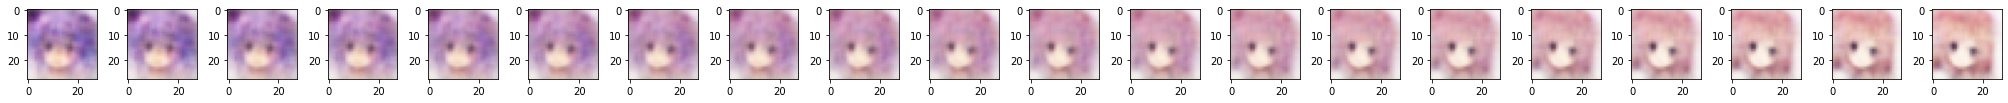

In [179]:
x1 = -1
x2 = -1
for idx, imagedata in enumerate(val_loader, 0):
      imgs= imagedata
      #print(imgs.size()[0])
      for i in range(imgs.size()[0]):
        x1 = imgs[i].to(device)
        x2 = imgs[i+1].to(device)
        break
      break
interpolate(net.to(device), x1*1.0, x2*1.0, n=20)

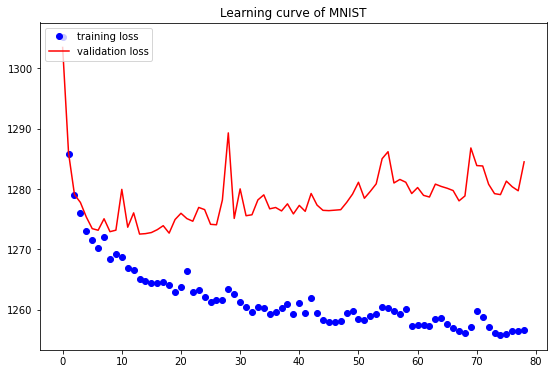

In [176]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Learning curve of MNIST")
plt.legend(loc='upper left')
plt.show()

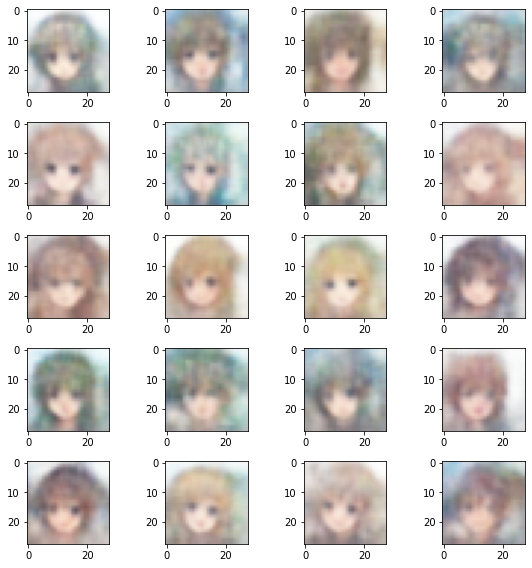

In [181]:
# img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
# outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
# f, axarr = plt.subplots(5,5) 
# axarr[0].imshow(np.squeeze(img), interpolation='nearest')
# axarr[1].imshow(np.squeeze(outimg), interpolation='nearest')

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    outimg = np.transpose(out[i-1].cpu().detach().numpy(), [1,2,0])
    plt.imshow(np.squeeze(outimg))
plt.show()

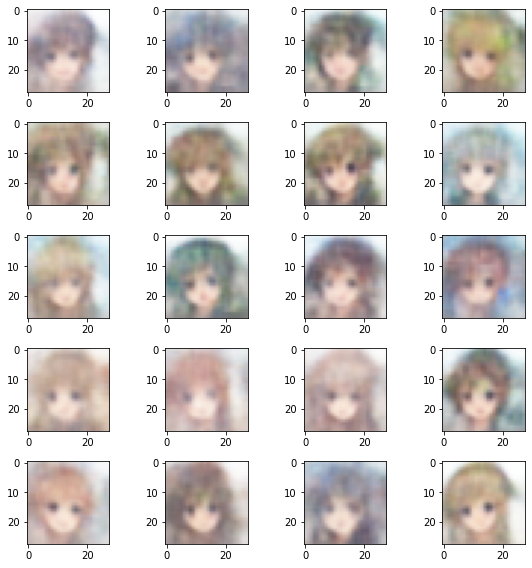

In [182]:
sample = np.random.binomial(1, 0.5, size=(20, 256))
sample = torch.from_numpy(np.float32(sample)).to(device)
out = net.decoder(sample)

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    outimg = np.transpose(out[i-1].cpu().detach().numpy(), [1,2,0])
    plt.imshow(np.squeeze(outimg))
plt.show()